## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact

%matplotlib inline

In [3]:
def display_images(images):
    plt.rcParams['figure.figsize'] = [10,6]

    #display images
    ncols = 2
    nrows = len(images) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout()

    count = 0
    for i in range(nrows):
        for j in range(ncols):
            axes[i][j].imshow(images[count])
            count += 1

### Compute object and image points 

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

processed_images = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        processed_images.append(img)     



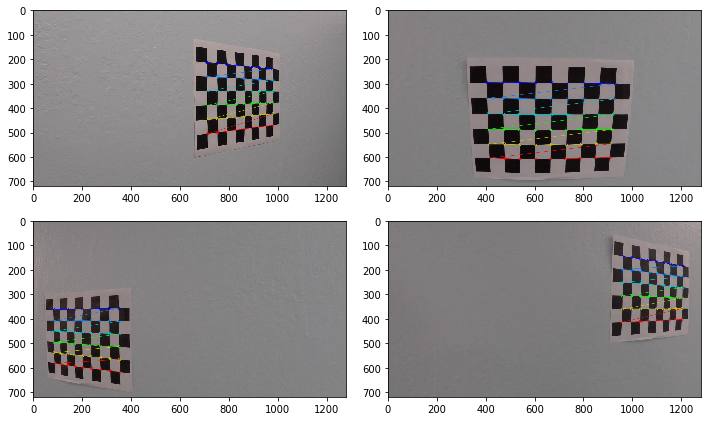

In [5]:
display_images(processed_images[:4])

### Calibrate Camera

In [6]:
#Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [7]:
def undistort(image):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [8]:
def bgr2rgb(image):
    return image[...,::-1]

In [9]:
#undistort test images
test_images = glob.glob('test_images/*.jpg')
processed_test_images = []
for fname in test_images:
    img = cv2.imread(fname)
    img = bgr2rgb(img)
    processed_test_images.append(img)
    processed_test_images.append(undistort(img))    

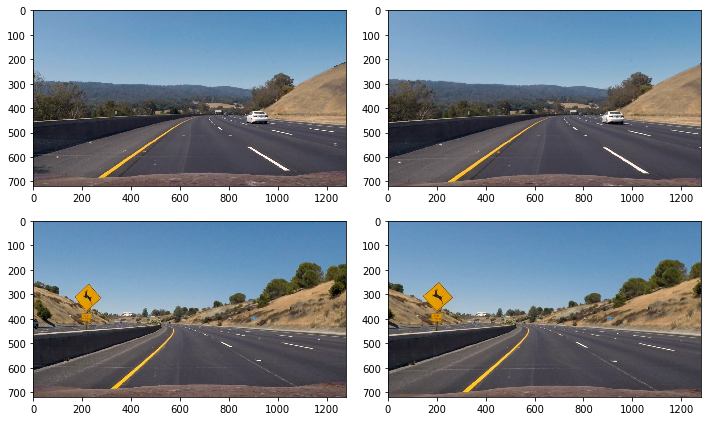

In [10]:
display_images(processed_test_images[:4])

## Thresholded Binary Image

### Gradient Threshold

In [11]:
#The function takes in an RGB image, gradient orientation, and threshold min / max values.
# Returns thresholded image
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh = (0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [12]:
# The function returns the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [13]:
# The function thresholds an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [14]:
def combined_threshold(image, kernel_size=3, 
                       x_thresh=(0,255), 
                       y_thresh=(0,255), 
                       mag_thresh=(0,255), 
                       dir_thresh=(0, np.pi/2)):
    gradx = abs_sobel_threshold(image, orient='x', sobel_kernel=kernel_size, thresh=x_thresh)
    grady = abs_sobel_threshold(image, orient='y', sobel_kernel=kernel_size, thresh=y_thresh)
    mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    

In [67]:
def display_images_compare(images_a, images_b):
    plt.rcParams['figure.figsize'] = [10,6]

    #display images
    ncols = 2
    nrows = len(images_a)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout()

    count = 0
    for i in range(nrows):
            axes[i][0].imshow(images_a[count])
            axes[i][1].imshow(images_b[count], cmap='gray')
            count += 1

In [68]:
grad_thresholded_imgs = []
for image in processed_test_images:        
    #thresh_img = combined_threshold(image, kernel_size=15, x_thresh=(30,100), y_thresh=(50,130), 
    #                                mag_thresh=(30,100), dir_thresh=(0.9, 1.1))
    thresh_img = abs_sobel_threshold(image, sobel_kernel=21, thresh=(30,130))
    
    grad_thresholded_imgs.append(thresh_img)    

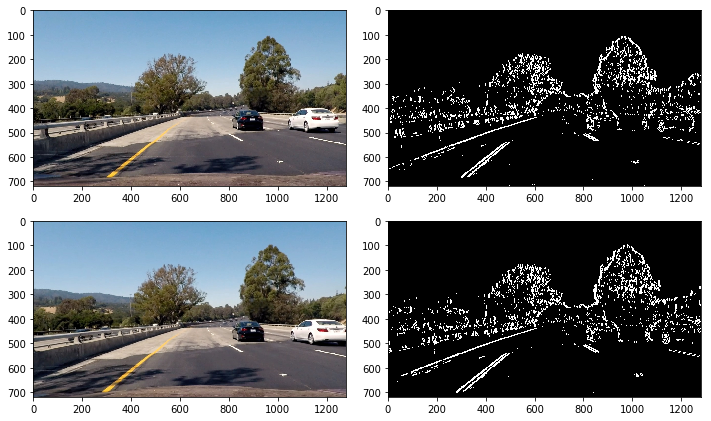

In [69]:
display_images_compare(processed_test_images[4:6], grad_thresholded_imgs[4:6])

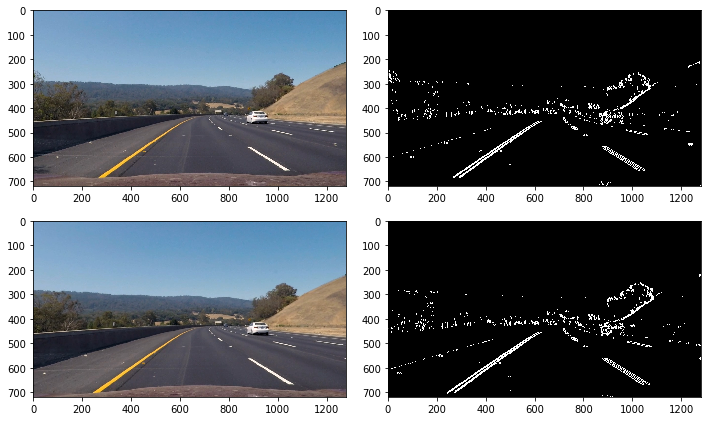

In [43]:
display_images_compare(processed_test_images[0:2], grad_thresholded_imgs[0:2])

### Color Threshold

In [22]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [23]:
color_thresholded_imgs = []
for image in processed_test_images:        
    thresh_img = hls_select(image, thresh=(170,255))
    color_thresholded_imgs.append(thresh_img)    

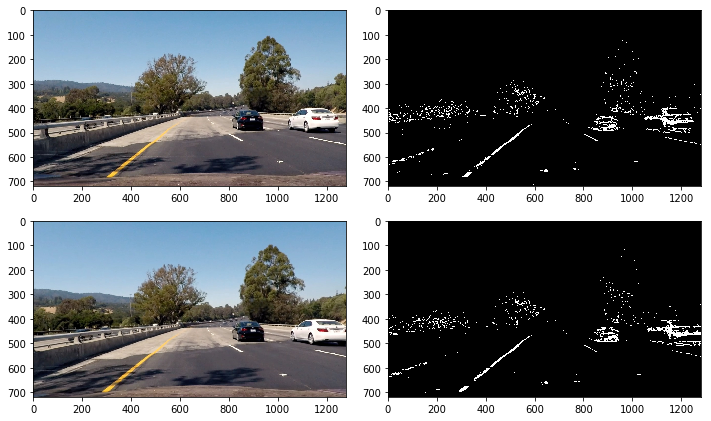

In [24]:
display_images_compare(processed_test_images[4:6], color_thresholded_imgs[4:6])

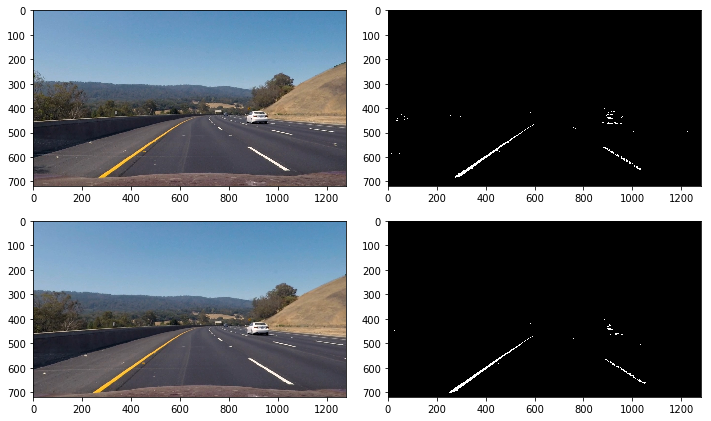

In [25]:
display_images_compare(processed_test_images[0:2], color_thresholded_imgs[0:2])

### Combine Color and Gradient Thresholds

In [26]:
color_binary_imgs = []
combined_binary_imgs = []
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
for grad, color in zip(grad_thresholded_imgs, color_thresholded_imgs):
    
    color_binary = np.dstack(( np.zeros_like(grad), grad, color)) * 255
    color_binary_imgs.append(color_binary)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad)
    combined_binary[(grad == 1) | (color == 1)] = 1

    combined_binary_imgs.append(combined_binary)   


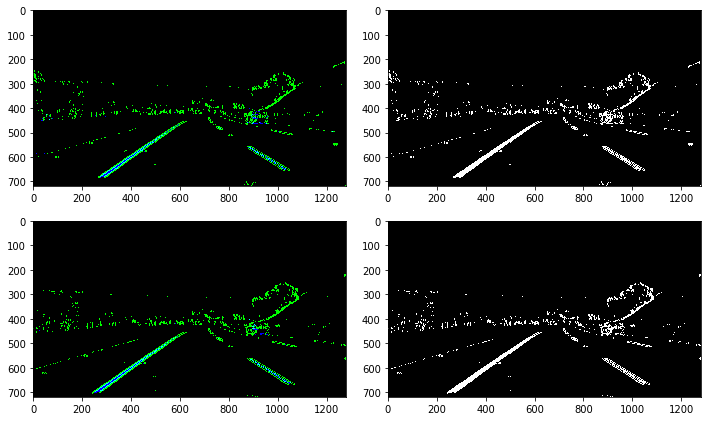

In [27]:
display_images_compare(color_binary_imgs[0:2], combined_binary_imgs[0:2])

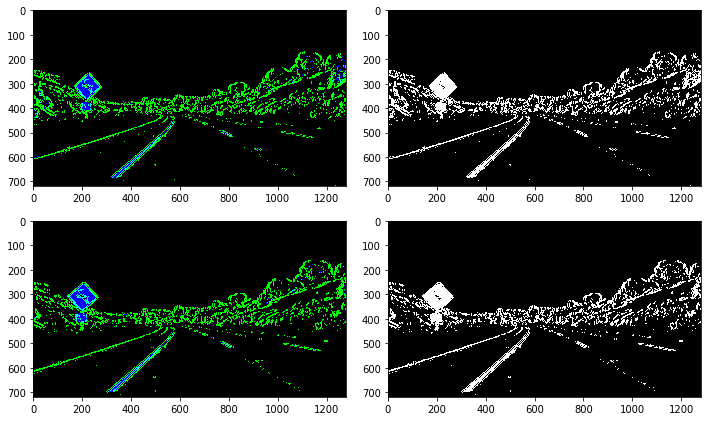

In [28]:
display_images_compare(color_binary_imgs[2:4], combined_binary_imgs[2:4])

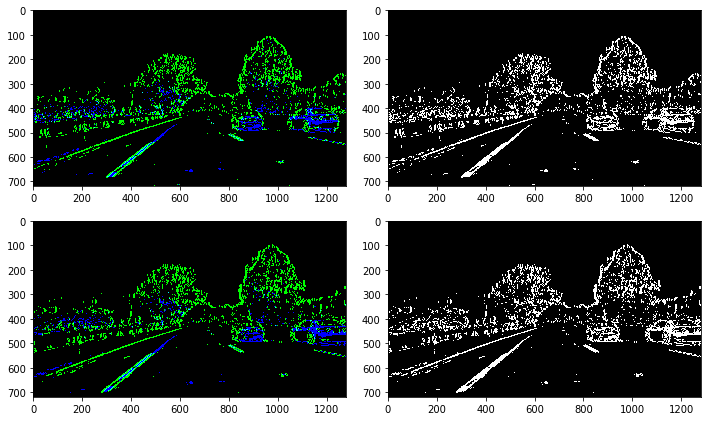

In [29]:
display_images_compare(color_binary_imgs[4:6], combined_binary_imgs[4:6])

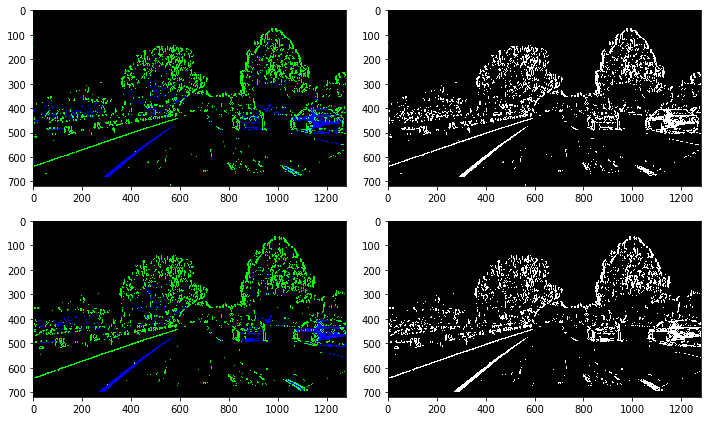

In [30]:
display_images_compare(color_binary_imgs[6:8], combined_binary_imgs[6:8])

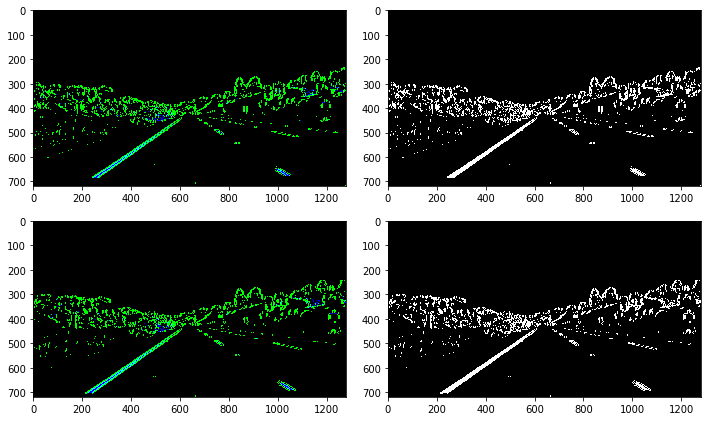

In [31]:
display_images_compare(color_binary_imgs[8:10], combined_binary_imgs[8:10])

## Perspective Transform

### Find trapezoid coordinates

In [32]:
#find source points on straight images
straight_images = glob.glob('test_images/straight*.jpg')
processed_straight_images = []
for fname in straight_images:
    img = cv2.imread(fname)
    img = bgr2rgb(img)
    processed_straight_images.append(img)    

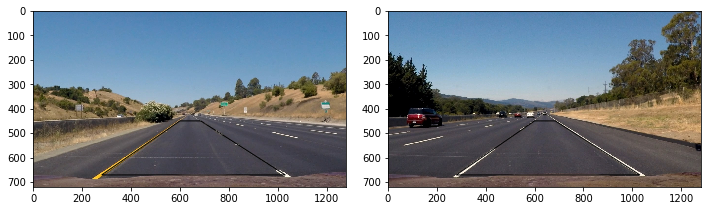

In [33]:
plt.rcParams['figure.figsize'] = [10,6]
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
    
# Trapezoid
x = [280,600,685,1031]
y = [671,450,450,671]

# Display the image
axes[0].imshow(processed_straight_images[0])
axes[1].imshow(processed_straight_images[1])

axes[0].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
axes[1].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))

plt.show()

### Compute Transform

In [54]:
src = np.float32([
    [280, 671],
    [600, 450],
    [685, 450],
    [1031, 671]
])

dst = np.float32([
    [280, 671],
    [280, 0],
    [1031, 0],
    [1031, 671]
])
    
perspective_transform = cv2.getPerspectiveTransform(src, dst)    

In [64]:
def get_warped(image):
    img_size = (image.shape[1], image.shape[0])    
    warped = cv2.warpPerspective(image, perspective_transform, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [65]:
transformed_imgs = []
for image in combined_binary_imgs:
    transformed_imgs.append(get_warped(image))

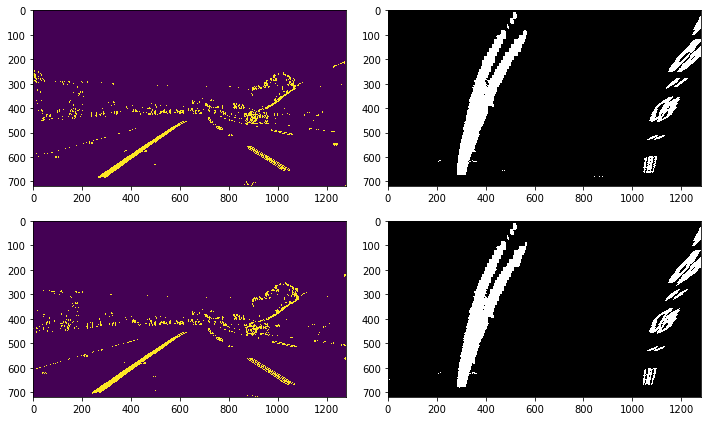

In [74]:
display_images_compare(combined_binary_imgs[0:2], transformed_imgs[0:2])

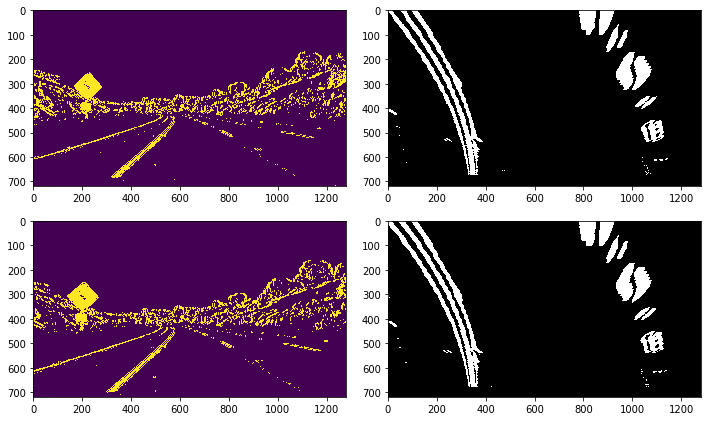

In [75]:
display_images_compare(combined_binary_imgs[2:4], transformed_imgs[2:4])

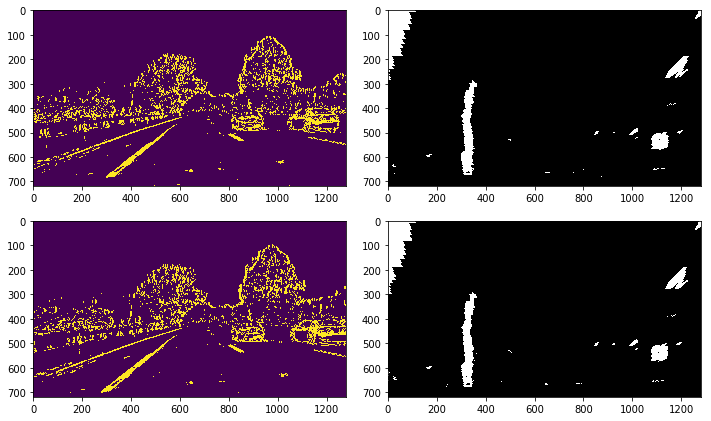

In [76]:
display_images_compare(combined_binary_imgs[4:6], transformed_imgs[4:6])

## Find Lanes